# Post-Lab: Extracting and Analyzing Ksp Data from OT-2 JSON Logs

In this notebook, you'll:
1. Load your experimental data from a JSON file created by the OT-2 robot.
2. Extract the volume data for each well.
3. Add a column to indicate whether each well showed precipitation.
4. Fit a non-linear boundary curve to estimate the solubility line.

### Extracting the data from the json file

Drag and drop you json file in the file list to the left and work your way through this workbook.

In [3]:
# Step 1: Upload your JSON file using the sidebar file uploader.

# After uploading, set the filename below.

json_filepath = "JSONFILE_2.json" # Your Code Here

In [5]:
import json
import os
import pandas as pd

# Load the JSON file
def load_json(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")
    
    with open(filepath, 'r') as file:
        data = json.load(file)
    return data

# Extract relevant data
def extract_dispense_data(data, cu_well="A2", gly_well="A3"):
    well_data = {}
    last_aspirate_source = None  # Track last aspirate command
    
    for entry in data.get("commands", {}).get("data", []):
        if entry.get("commandType") == "aspirate":
            last_aspirate_source = entry["params"]["wellName"]
        
        elif entry.get("commandType") == "dispense":
            well = entry["params"]["wellName"]
            volume = entry["params"]["volume"]
            
            if last_aspirate_source == cu_well:
                if well not in well_data:
                    well_data[well] = {"Cu (µL)": 0, "Gly (µL)": 0}
                well_data[well]["Cu (µL)"] += volume
            elif last_aspirate_source == gly_well:
                if well not in well_data:
                    well_data[well] = {"Cu (µL)": 0, "Gly (µL)": 0}
                well_data[well]["Gly (µL)"] += volume
    
    return well_data

# Convert extracted data to a DataFrame
def create_dataframe(well_data):
    df = pd.DataFrame.from_dict(well_data, orient='index').reset_index()
    df.rename(columns={'index': 'Well'}, inplace=True)
    return df

# Main execution function
def main(filepath):
    data = load_json(filepath)
    well_data = extract_dispense_data(data)
    df = create_dataframe(well_data)
    pd.set_option('display.max_rows', None)  # Ensure all rows are printed
    pd.set_option('display.max_columns', None)  # Ensure all columns are printed
    print(df)
    df.to_csv("extracted_data.csv", index=False)

### Create volume fraction columns

In [7]:
# Step 2: Run the data extraction and view your results

df = create_dataframe(extract_dispense_data(load_json(json_filepath)))

df['Cu Fraction'] = df['Cu (µL)'] / 75

# Step 3: Now create another data frame for the Gly Fractions
# Your code here

In [11]:
# Step 4: Manually assess each well and enter 'y' or 'n' in the Flag column

flags = ["n","n","n","n","n","n","n","y","n","n","n","n","n","n","n","y",
         "n","n","n","n","y","n","y","n","n","n","n","n","n","n","n","n",
         "n","n","n","n","n","n","n","n","n","n","y","n","n","n","n","n",
         "n","n","n","n","n","n","n","n","n","n","n","n","n","n","n","n",
         "n","n","n","n","n","n","n","n","n","n","n","n","n","n","n","y",
         "n","n","n","n","n","n","y","n","y","n","n","n","n","n","n","n"]

# for well in df['Well']:
#     flags.append(input(f"Did well {well} precipitate? (y/n): "))
df['Flag'] = flags


,Well,Cu (µL),Gly (µL),Cu Fraction,Gly Fraction,Flag
0,A1,34.776127,11.846925,0.463682,0.157959,n
1,B1,17.755418,9.713516,0.236739,0.129514,n
2,C1,13.975606,29.280891,0.186341,0.390412,n
3,D1,18.779513,27.385406,0.250394,0.365139,n
4,E1,15.498299,57.563189,0.206644,0.767509,n


After filling in the `Flag` column (precipitation: 'y', no precipitate: 'n'), continue with the plot and regression steps below.

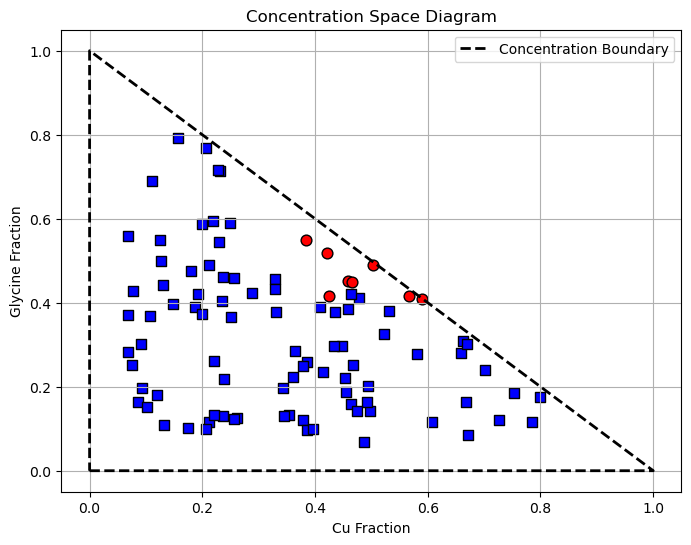

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Filter and prep data
filtered_df = df[df['Flag'].isin(['y', 'n'])].copy()
colors = filtered_df['Flag'].map({'y': 'red', 'n': 'blue'})
markers = filtered_df['Flag'].map({'y': 'o', 'n': 's'})

# Step 5: Now using your programming knowledge use matplotlib to plot a concentration space graph  

# Plot points
# Your code here

# Plots reference triangle
triangle_x = [0, 1, 0, 0]
triangle_y = [0, 0, 1, 0]
plt.plot(triangle_x, triangle_y, 'k--', lw=2, label='Concentration Boundary')

# Set axis, title, etc
# Your code here

With the knowledge that the Ksp equation is ksp = [Cu][Gly], we can use non-linear regression to fit a ksp equation to the data

In [30]:
# Step 6: Non-linear regression to fit solubility boundary

from scipy.optimize import curve_fit

def ksp_model(x, a):
    return a / x

fit_data = filtered_df[filtered_df['Flag'] == 'y']

# Setting the x data
xdata = fit_data['Cu Fraction'].values

# Now do the same with the y data
ydata = fit_data['Gly Fraction'].values

# We will be using curve_fit model to fit out data as seen below
popt, _ = curve_fit(ksp_model, xdata, ydata, p0=[0.18, 0])

print(f"Fitted curve: y = {popt[0]:.4f}/x")

Fitted curve: y = 0.2147/x


C:\Users\Harry\AppData\Local\Temp\ipykernel_4748\4277174611.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(ksp_model, xdata, ydata, p0=[0.18, 0])


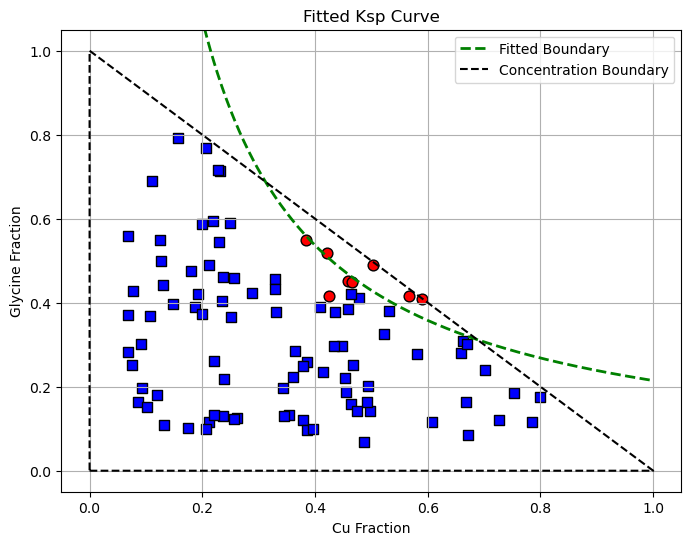

In [36]:
# Step 5: Plot data with fitted curve
xrange = np.linspace(0.01, 1, 500) 
yfit = ksp_model(xrange, *popt)

# Keep only (x, y) pairs where x + y <= 2
valid_mask = (xrange + yfit) <= 2
x_filtered = xrange[valid_mask]
y_filtered = yfit[valid_mask]

plt.figure(figsize=(8, 6))

# Plot the filted data
for i in range(len(filtered_df)):
    plt.scatter(filtered_df.iloc[i]['Cu Fraction'], filtered_df.iloc[i]['Gly Fraction'],
                color=colors.iloc[i], marker=markers.iloc[i], edgecolor='k', s=60)

# Plot only the valid section of the fitted curve
plt.plot(x_filtered, y_filtered, 'g--', linewidth=2, label='Fitted Boundary')

# Add triangle boundary for context
plt.plot([0, 1, 0, 0], [0, 0, 1, 0], 'k--', lw=1.5, label="Concentration Boundary")

plt.xlabel("Cu Fraction")
plt.ylabel("Glycine Fraction")
plt.title("Fitted Ksp Curve")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.show()
